In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Load channels, members, and emojis

In [2]:
channels = pd.read_csv('../info/channels_labeled.csv')
members = pd.read_csv('../info/members_labeled.csv')
emojis = pd.read_csv('../info/emojis.csv')

In [3]:
channels.head()

,channel_id,channel_name,created_date,created_by,folder,actual_name,folder_name
0,C0GQ664PQ,general,2015-12-16,Paul,others,general,general
1,C0GQ0GH1S,random,2015-12-16,Paul,others,random,random
2,CBH1274KV,msan501,2018-07-01,Terence,mod1_summer,Computation for Analytics,computation_for_analytics
3,CBL5QGXCG,msan502-2018,2018-07-08,Kirsten,mod1_summer,Linear Algebra,linear_algebra
4,CBMV8E51R,msan504_2018,2018-07-10,Jeff,mod1_summer,Probability and Statistics,probability_and_statistics


In [4]:
members.head(3)

,member_id,member_name,member_type,country
0,U9WDUU4LE,GitHub,bot,NaN
1,USLACKBOT,Slackbot,bot,NaN
2,UAZK0M7RR,Polly,bot,NaN


In [5]:
emojis.head()

,name,image,type
0,hash,../info/default_emojis/hash.png,default
1,keycap_star,../info/default_emojis/keycap_star.png,default
2,zero,../info/default_emojis/zero.png,default
3,one,../info/default_emojis/one.png,default
4,two,../info/default_emojis/two.png,default


# Load messages

In [6]:
root = "../data"

In [7]:
# Get path to all json files in the data folder
json_files = []
for path, subdirs, files in os.walk(root):
    for file in files:
        if file.endswith(".json"):
            p = os.path.join(path, file)
            module = p.split("/")[2]
            channel = p.split("/")[3].split(".")[0]
            json_files.append([module,channel,p])
json_files = sorted(json_files, key=lambda kv: (kv[0],kv[1]), reverse=False)

In [8]:
def create_df_from_json(path):
    with open(path) as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["ts"] = pd.to_numeric(df["ts"])
    df["ts"] = df["ts"].apply(lambda ts: dt.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
    df = df[['text','reactions','ts','user','parent_user_id', 'files']]
    return df

In [9]:
dfs = []
for file in json_files:
    module = file[0]
    course = file[1]
    path = file[2]
    df = create_df_from_json(path)
    df['module'] = module
    df['course'] = course
    dfs.append(df) 

In [10]:
all_messages = pd.concat(dfs).reset_index().drop(columns=['index'])
all_messages.head()

,text,reactions,ts,user,parent_user_id,files,module,course
0,<@UBMMHRHE2> has left the channel,NaN,2019-04-26 11:08:19,UBMMHRHE2,NaN,NaN,mod1_summer,computation_for_analytics
1,<@UBKUL888Y> has left the channel,NaN,2019-04-09 10:44:11,UBKUL888Y,NaN,NaN,mod1_summer,computation_for_analytics
2,<@UBLC0B98U> has left the channel,NaN,2019-03-27 20:38:38,UBLC0B98U,NaN,NaN,mod1_summer,computation_for_analytics
3,<@UBL0QKZ9N> has left the channel,NaN,2019-03-19 21:16:21,UBL0QKZ9N,NaN,NaN,mod1_summer,computation_for_analytics
4,<@UBMJ5RRGE> has left the channel,NaN,2019-02-15 01:10:26,UBMJ5RRGE,NaN,NaN,mod1_summer,computation_for_analytics


# Some counting

In [11]:
def count_reactions(message_reactions):
    if isinstance(message_reactions, list):
        return sum([d['count'] for d in message_reactions])
    return 0

In [12]:
all_messages['count_reactions'] = all_messages['reactions'].apply(lambda message_reactions: count_reactions(message_reactions))

In [13]:
all_messages.groupby(['course']).sum().reset_index().sort_values(by=['count_reactions'], ascending=False)

,course,count_reactions
20,random,6876
13,general,5905
5,computational_statistics,2330
16,linear_regression_analysis,1775
0,advanced_machine_learning,1683
11,experiments_in_data_science,1548
2,cats,1518
1,awkwards,1492
19,product_analytics,1491
8,distributed_computing,1456


In [14]:
all_messages.groupby(['module']).sum().reset_index().sort_values(by=['count_reactions'], ascending=False)

,module,count_reactions
6,others,16355
4,mod5_spring1,5011
5,mod6_spring2,3822
2,mod3_fall2,3698
1,mod2_fall1,3594
0,mod1_summer,2274
3,mod4_winter,945


In [15]:
all_messages['date'] = all_messages['ts'].apply(lambda ts: ts.split()[0])
reactions_by_day = all_messages.groupby(['date']).sum().reset_index()

date_format = "%Y-%m-%d"
a = dt.strptime(reactions_by_day.date.min(), date_format)

reactions_by_day['date_encoded'] = reactions_by_day.date.apply(lambda d: (dt.strptime(d, date_format) - a).days+1)

reactions_by_day.sort_values(by=['count_reactions'], ascending=False).head(10)

,date,count_reactions,date_encoded
238,2019-03-04,861,243
133,2018-11-15,838,134
240,2019-03-06,541,245
241,2019-03-07,535,246
276,2019-04-11,520,281
253,2019-03-19,513,258
231,2019-02-25,489,236
113,2018-10-26,471,114
206,2019-01-31,439,211
291,2019-04-26,428,296


### Count reactions per day

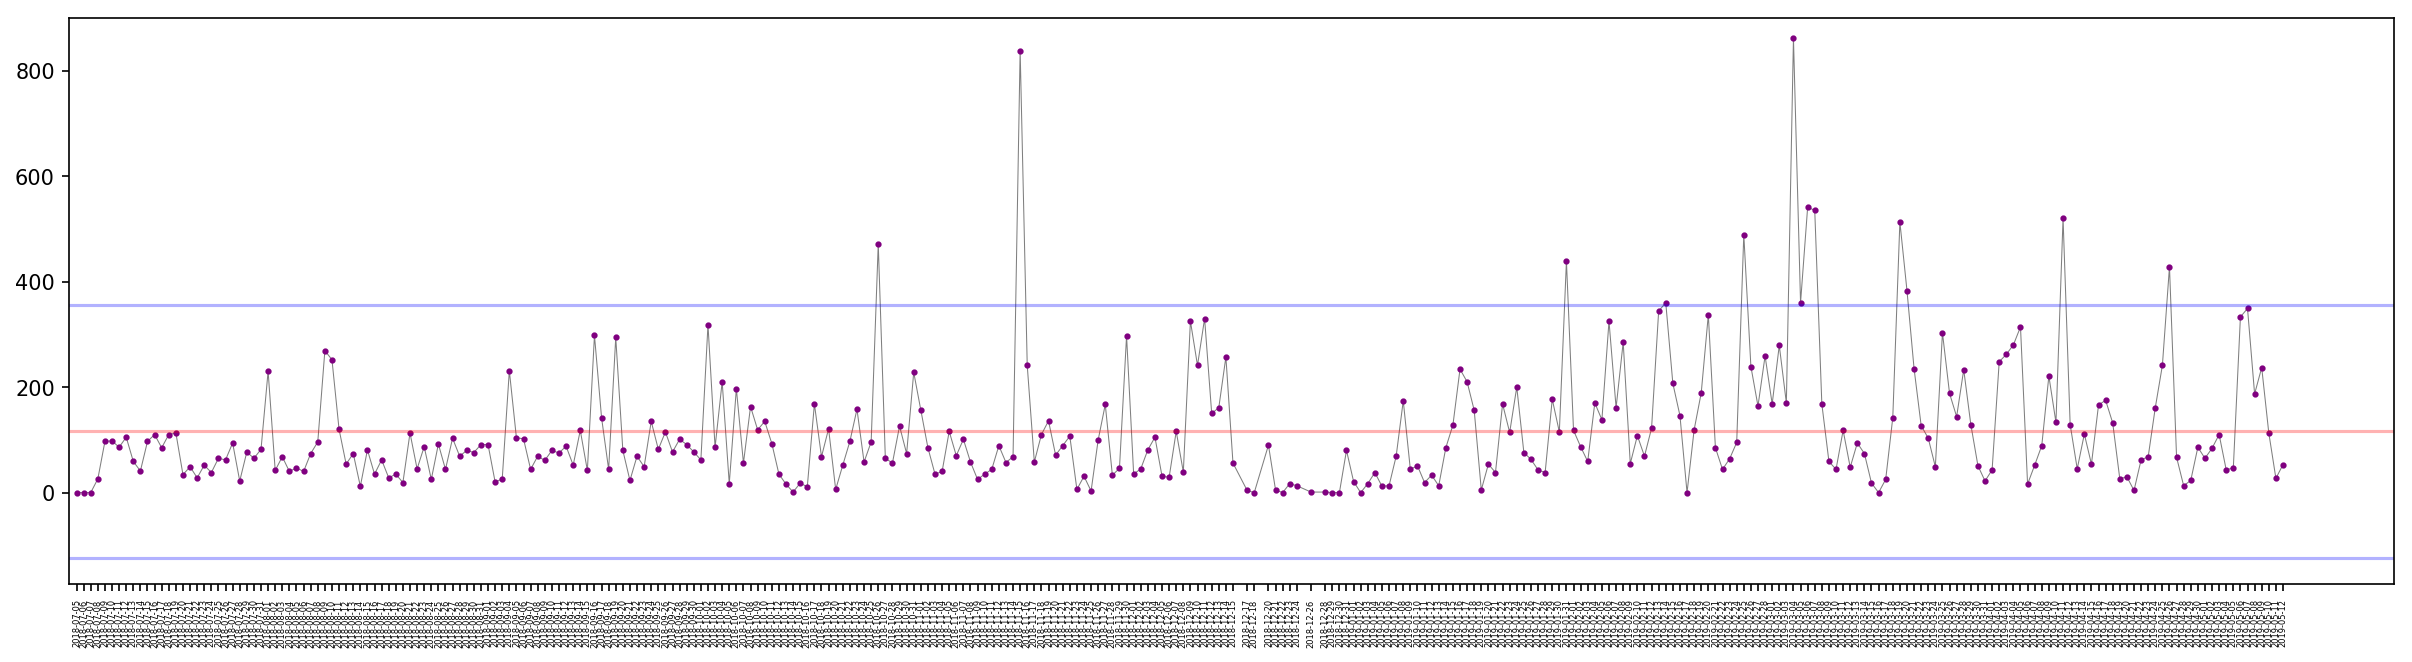

In [16]:
mpl.rcParams['figure.dpi'] = 150
f = plt.figure(figsize=(20,5))

x = reactions_by_day.date_encoded.values # x-axis
x_ticks = reactions_by_day.date.values
y = reactions_by_day.count_reactions.values # y-axis

plt.plot(x,y,color="black", alpha=0.5, zorder=1, linewidth=0.5)
plt.scatter(x, y, color="purple", zorder=2, s=4)
plt.title("")

plt.axhline(y=round(reactions_by_day.count_reactions.mean())+round(reactions_by_day.count_reactions.std())*2, color='b', alpha=0.3, linestyle='-')
plt.axhline(y=round(reactions_by_day.count_reactions.mean()), color='r', alpha=0.3, linestyle='-')
plt.axhline(y=round(reactions_by_day.count_reactions.mean())-round(reactions_by_day.count_reactions.std())*2, color='b', alpha=0.3, linestyle='-')

plt.xlim(left=0)
plt.ylim(top=900)
plt.xticks(reactions_by_day.date_encoded.unique(), reactions_by_day.date.unique(), rotation='90', fontsize=4);

In [17]:
all_messages.head()

,text,reactions,ts,user,parent_user_id,files,module,course,count_reactions,date
0,<@UBMMHRHE2> has left the channel,NaN,2019-04-26 11:08:19,UBMMHRHE2,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-04-26
1,<@UBKUL888Y> has left the channel,NaN,2019-04-09 10:44:11,UBKUL888Y,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-04-09
2,<@UBLC0B98U> has left the channel,NaN,2019-03-27 20:38:38,UBLC0B98U,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-03-27
3,<@UBL0QKZ9N> has left the channel,NaN,2019-03-19 21:16:21,UBL0QKZ9N,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-03-19
4,<@UBMJ5RRGE> has left the channel,NaN,2019-02-15 01:10:26,UBMJ5RRGE,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-02-15


In [18]:
all_messages.to_csv("../info/messages.csv", index=False)